# Channel Flow (Steady) DEMO code

This notebook demonstrates solving steady-state channel flow (uniform inlet) using Physics-Informed Neural Networks (PINNs).

In [ ]:
import deepflow as df
print("deepflow is currently run on:", df.device)

## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [ ]:
rectangle = df.Geometry.rectangle([0,1], [0,1])

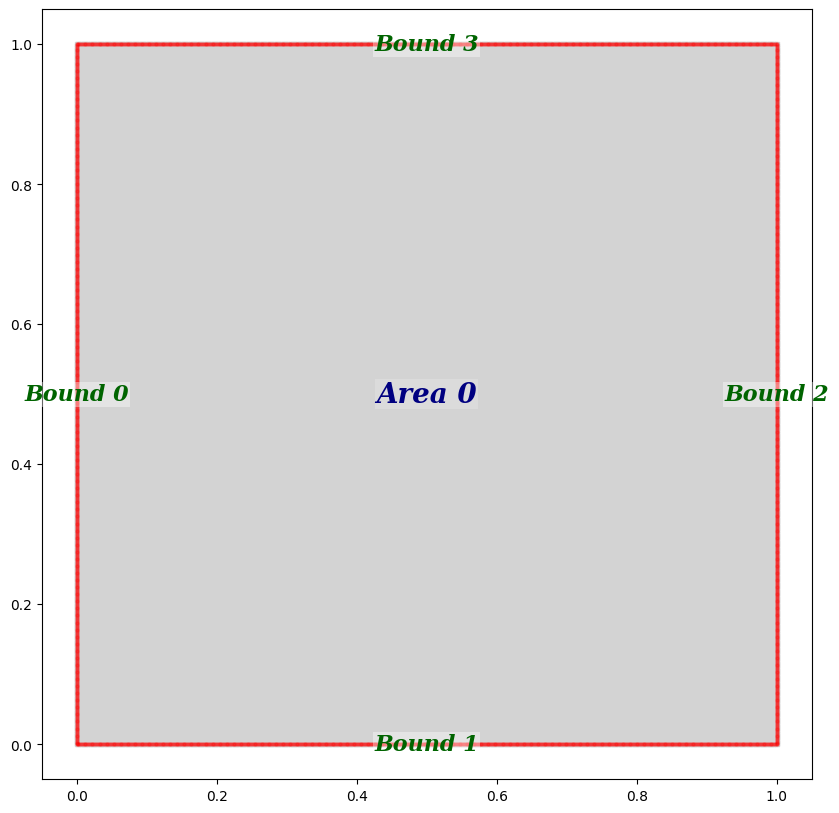

In [ ]:
domain = df.domain(rectangle.bound_list, rectangle)
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

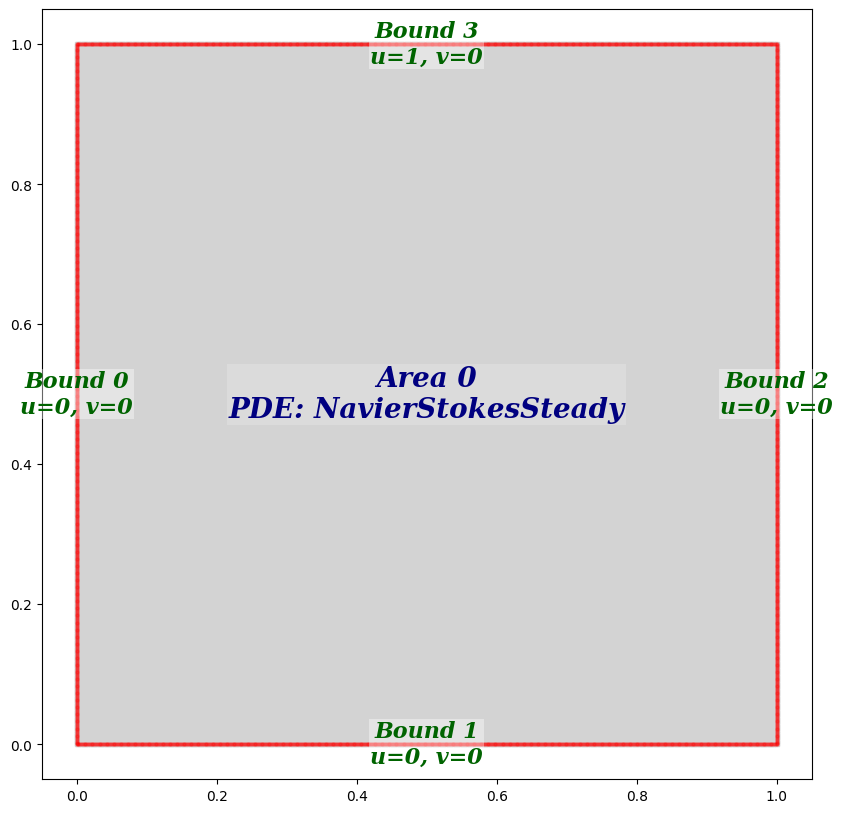

In [ ]:
domain.bound_list[0].define_bc({'u':0,'v':0})
domain.bound_list[1].define_bc({'u':0,'v':0})
domain.bound_list[2].define_bc({'u':0,'v':0})
domain.bound_list[3].define_bc({'u':1,'v':0})
domain.area_list[0].define_pde(df.NavierStokesSteady(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()


Sample initial points for training. Required if using Residual-based Adaptive Refinement (RAR).

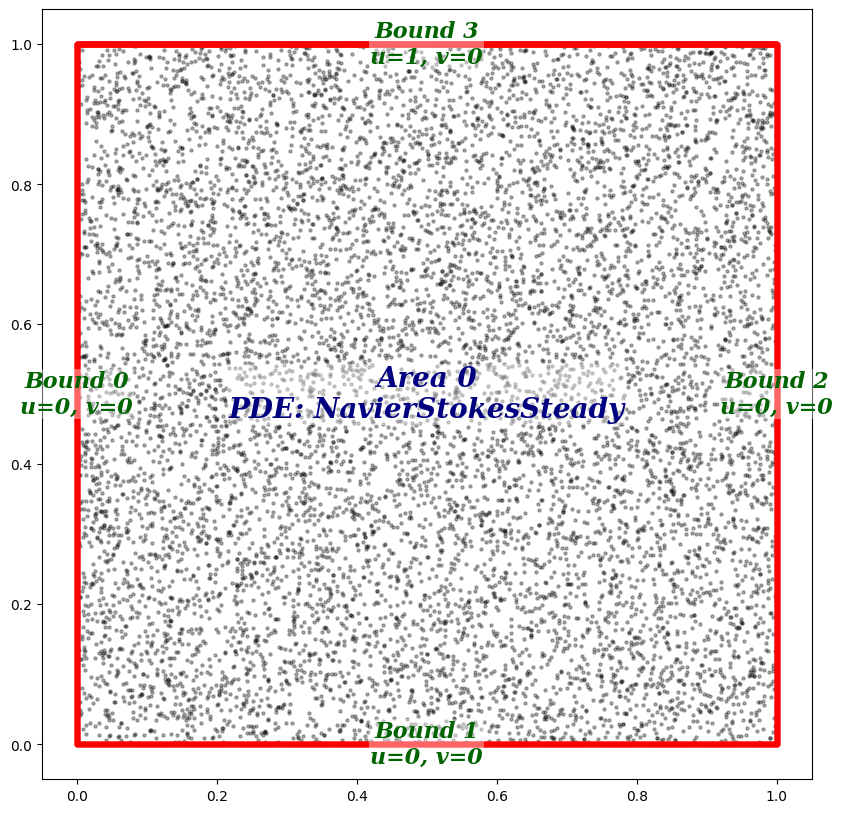

In [ ]:
domain.sampling_uniform(bound_sampling_res=[2000, 2000, 2000, 4000])
domain.sampling_random_r(area_sampling_res=[10000])
domain.show_coordinates(display_conditions=True)

## 3. Train the PINN model
Initialize a PINN with specified width and depth.

In [ ]:
model0 = df.PINN(width=50, length=5)

Design how to compute loss from boundary conditions and PDE residuals

In [ ]:
# Define the loss calculation function
import time
def calc_loss(model):

    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        bc_loss += bc.calc_loss(model)

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model)

    # Total Loss
    total_loss = bc_loss + 10*pde_loss # weight bc_loss more

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss} # MUST RETURN IN THIS FORMAT)

Train the model using Adam for initial training (faster convergence).

In [ ]:
# Train the model
model1, model1_best = model0.train_adam(
    calc_loss=calc_loss,
    learning_rate=0.001,
    epochs=2000,
    print_every=200,
    threshold_loss=0.01,
    has_scheduler=True
)

KeyboardInterrupt: 

Refine the model using LBFGS for higher precision.

In [ ]:
# Train the model
model2 = model1_best.train_lbfgs(
    calc_loss=calc_loss,
    epochs=500,
    print_every=50,
    threshold_loss=0.001)

epoch 1982, total_loss: 0.07126, bc_loss: 0.06663, pde_loss: 0.00046
epoch 2032, total_loss: 0.04421, bc_loss: 0.03902, pde_loss: 0.00052
epoch 2082, total_loss: 0.02510, bc_loss: 0.02043, pde_loss: 0.00047
epoch 2132, total_loss: 0.01305, bc_loss: 0.01062, pde_loss: 0.00024
epoch 2182, total_loss: 0.00906, bc_loss: 0.00766, pde_loss: 0.00014
epoch 2232, total_loss: 0.00698, bc_loss: 0.00583, pde_loss: 0.00011
epoch 2282, total_loss: 0.00566, bc_loss: 0.00469, pde_loss: 0.00010
epoch 2332, total_loss: 0.00475, bc_loss: 0.00402, pde_loss: 0.00007
epoch 2382, total_loss: 0.00409, bc_loss: 0.00343, pde_loss: 0.00007
epoch 2432, total_loss: 0.00358, bc_loss: 0.00301, pde_loss: 0.00006


Save or Load the model for later use

In [ ]:
import pickle
# # Save model with pickle
# with open("model2.pkl", "wb") as f:
#     pickle.dump(model2, f)

# Load model back
# with open("model2.pkl", "rb") as f:
#     model2 = pickle.load(f)

Show the final sampled points used in training

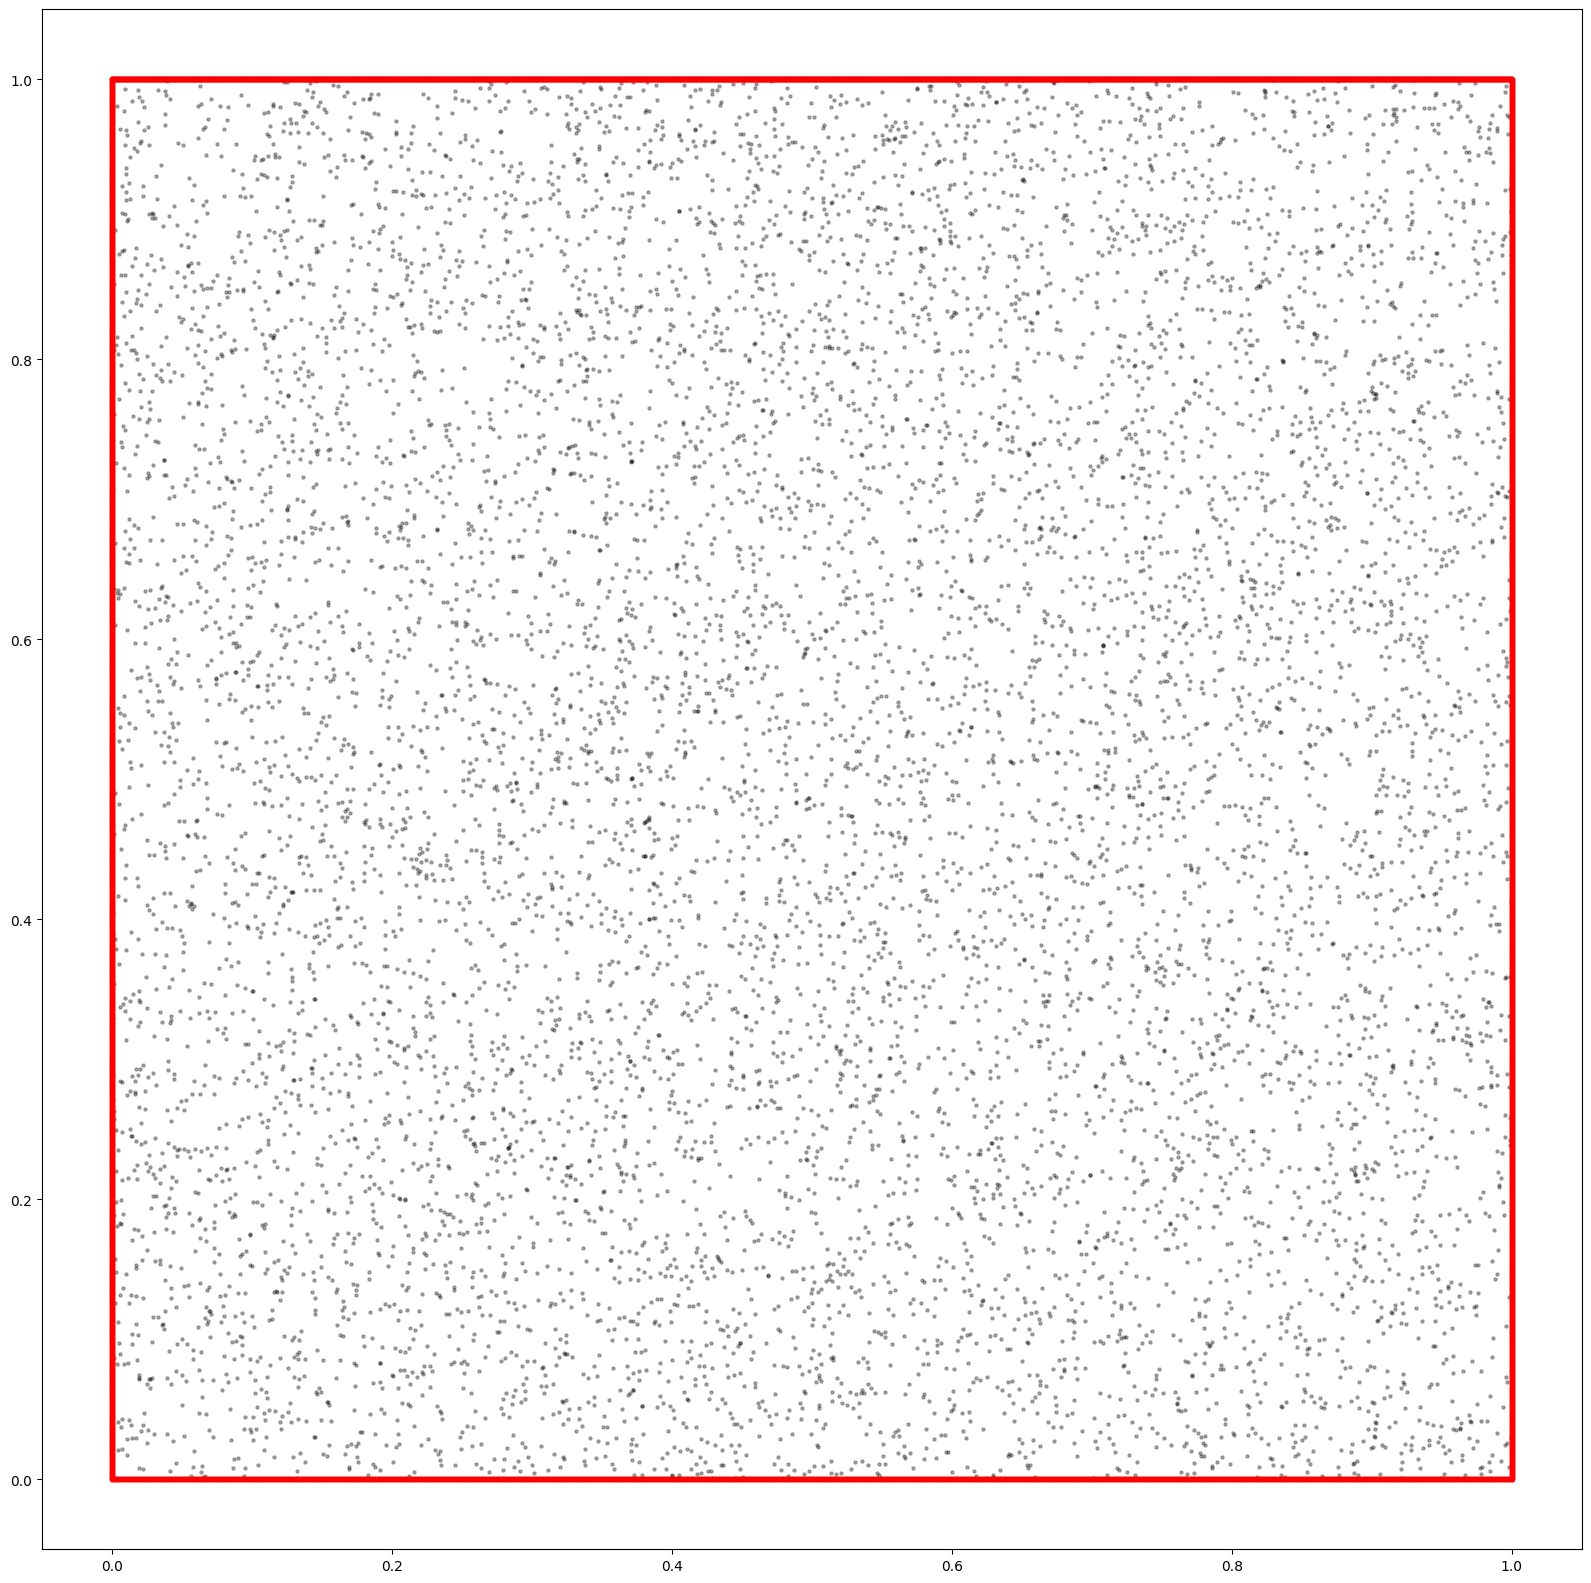

number of bound : 4
        ['0: 2000', '1: 2000', '2: 2000', '3: 4000']
        , number of area : 1
        ['0: 10000']


In [ ]:
domain.show_coordinates()
print(domain)

## 4. Visualization

### 4.1 Visualize area

In [ ]:
area_visual = domain.area_list[0].evaluate(model2) # Create object for evaluation (Need Model and Geometry)
area_visual.sampling_area(500, 500) # Sampling uniform points

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'PDE residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss')


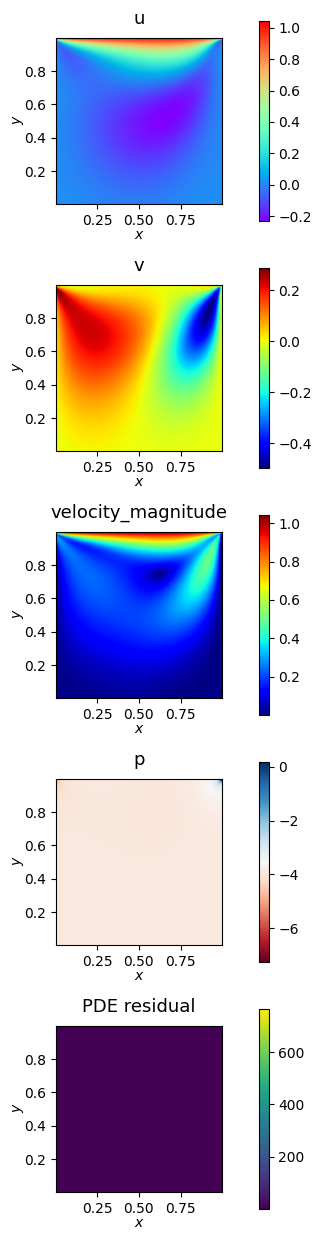

In [ ]:
cmap_dict = {
    'u':'rainbow',
    'v':'jet',
    'velocity_magnitude': 'jet',
    'p':'RdBu',
    'PDE residual': 'viridis'
}
colorplot_area_2d = area_visual.plot_data_on_geometry(cmap_dict, s=0.7)
colorplot_area_2d.savefig('colorplot_area_2d.png')

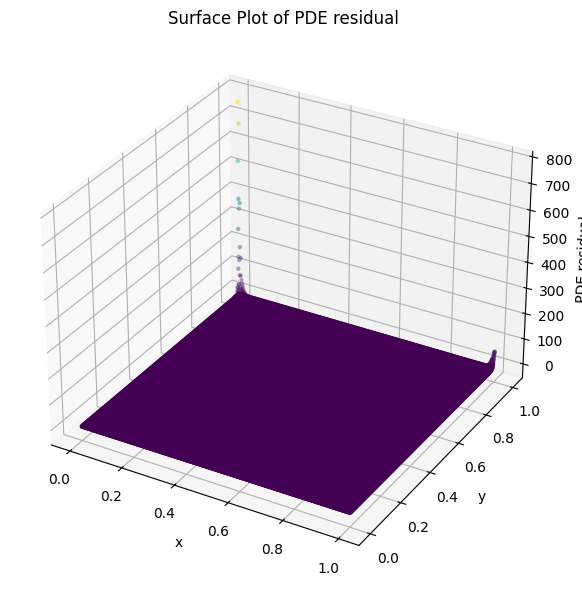

In [ ]:
residual_plot_3d = area_visual.plot_data('PDE residual')
residual_plot_3d.savefig('residual_plot_3d.png')

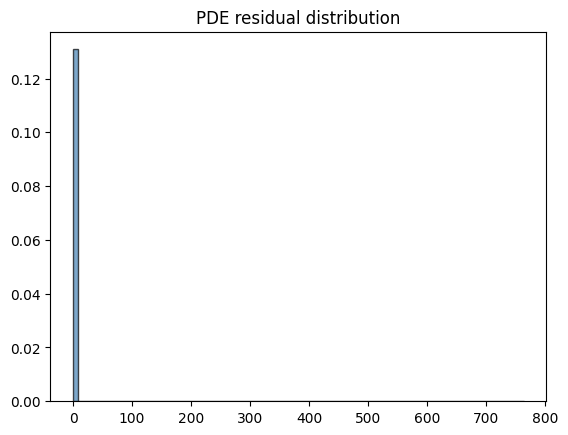

In [ ]:
residual_destribution = area_visual.plot_data_distribution('PDE residual', bins=100)

### 4.2 Visualize bound

In [ ]:
# Create object for evaluation (Need Model and Geometry)
bound_visual = domain.bound_list[0].evaluate(model2)
# Sampling uniform points
bound_visual.sampling_line(500)

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'BC residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss')


## 4.3 Visualize Neural Network data

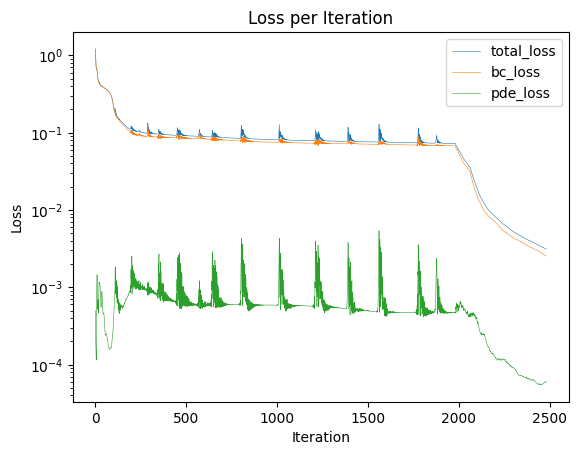

In [ ]:
loss_history = bound_visual.plot_loss_curve(log_scale=True, linewidth=0.4)
loss_history.savefig('loss_history.png')

### 4.4 Export data

In [ ]:
# display available options
print(bound_visual.data_dict.keys())

dict_keys(['u', 'v', 'p', 'velocity_magnitude', 'BC residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss'])


In [ ]:
# store the x,y,velocity_magnitude data
x_data = bound_visual.data_dict['x']
y_data = bound_visual.data_dict['y']
velocity_magnitude_data = bound_visual.data_dict['velocity_magnitude']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, velocity_magnitude_data))
np.savetxt('outlet_velocity_profile.txt', array)